# Data Cleaning

In [ ]:
#TODO data analysis esplorativa iniziale 
# quanti tweet per politico?
# quanti like per politico?
# quanti retweet?
# ...

# NOTE that here we also have retweets
#for politician in POLITICIANS:
#    print(politician + " " + str(len([tweet for tweet in date_filtered_data[politician] if "RT" not in tweet])))

## Importing libraries and data

In [1]:
import json
import os
import re
import pandas as pd

from datetime import datetime

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation, digits

In [2]:
RELEVANT_FIELDS = ["text", "created_at"]

def read_data(input_directory: str):
    input_data = dict()

    for filename in os.listdir(input_directory):
        if filename.endswith("json"):
            politician_name = filename.split(".")[0]

            file_location = os.path.join(input_directory, filename)
            file = open(file_location, "r")

            tweets = json.load(file)["tweets"]

            filtered_tweets = [{ key: tweet[key] for key in RELEVANT_FIELDS } for tweet in tweets]

            input_data[politician_name] = filtered_tweets
            
        else: 
            raise Exception(f"Input file {filename} has a non supported format.")
    return input_data

In [4]:
input_data = read_data("data")

## Defining cleaning function

- Remove stopwords
- Combine tweets that are part1 and part2
- DONE Remove tweets after a deadline (e.g. the midnight of the election)
- DONE Remove tweets before a deadline (e.g. max 3 months old) -> this is needed because we need to compare similar timeframes
- tokenization?
- stemming / lemmatization


In [ ]:
# TODO do we need to remove digits?
# TODO is it bad to split tweets into subsentences? -> TODO join multiple splitted tweets ((2/2))
# TODO note that there are tweets related to pics that we dont have
# TODO how to manage hashtags and citations (#/@)
# TODO create a pipeline funciton to use in pandas distributed-wise

In [5]:
# TODO create a pipeline funciton to use in pandas distributed-wise
def date_filter(tweet: dict, start_date = datetime(2022,7,22), end_date = datetime(2022,9,25)):
    created_at = datetime.strptime(tweet['created_at'], "%Y-%m-%dT%H:%M:%S.%fZ")
    return created_at >= start_date and created_at < end_date

def remove_links(tweet: dict):
    return re.sub(r'http\S+', '', tweet["text"])

def is_retweet(tweet: dict):
    return tweet["text"].startswith("RT @")

def preclean_tweet(tweet: dict):
    if date_filter(tweet) and not is_retweet(tweet):
        return remove_links(tweet)  
    else:
        return ""

In [8]:
POLITICIANS = list(input_data.keys())
filtered_data = {politician: list(filter(None, [preclean_tweet(tweet) for tweet in input_data[politician]])) for politician in POLITICIANS}

In [ ]:
filtered_data

In [ ]:
# Remove punctuation
# Remove stopwords
# Lemmatizer/Stemmer
# Tokenization

In [58]:
from nltk.tokenize import TweetTokenizer
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from string import punctuation
import nltk

nltk.download('stopwords')

ITALIAN_PUNCTUATION = punctuation + "’" # TODO add readibility


[nltk_data] Downloading package stopwords to /Users/billy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
stopw = set(stopwords.words('italian'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in ITALIAN_PUNCTUATION and word not in stopw and not word.startswith('http')] 

In [46]:
tokenized_data = {politician: [tokenize(tweet) for tweet in filtered_data[politician]] for politician in POLITICIANS}

In [126]:
# Stemmer

from nltk.stem import PorterStemmer, SnowballStemmer

# PorterStemmer()
# SnowballStemmer('italian')
# LancasterStemmer()
# RegexpStemmer('ita')

stem = lambda tokenized_text, stemmer: [stemmer.stem(word.lower()) for word in tokenized_text] 

stemmed_data = {politician: [stem(tweet, SnowballStemmer('italian')) for tweet in tokenized_data[politician]] for politician in POLITICIANS}

In [125]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('omw-1.4')

lemma = WordNetLemmatizer()

lemmatize = lambda tokenized_text, lemmatizer: [lemmatizer.lemmatize(word.lower(), lang="ita") for word in tokenized_text] 

lemmatized_data = {politician: [lemmatize(tweet, WordNetLemmatizer()) for tweet in tokenized_data[politician]] for politician in POLITICIANS}

[nltk_data] Downloading package wordnet to /Users/billy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/billy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


TypeError: lemmatize() got an unexpected keyword argument 'lang'

In [64]:
# cleaned_tweet = list()

# for tweet, lemmatized_tweet in zip(filtered_data["bonino"], lemmatized_data["bonino"]):
#     cleaned_tweet.append([tweet, lemmatized_tweet])

# pd.DataFrame(cleaned_tweet).to_csv("TBD/test_lemma.csv")

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [143]:
test_docs = [' '.join(tweet) for tweet in lemmatized_data_spacy["salvini"]]

#   tf–idf
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(test_docs)
# Convert to standard matrix
X_tfidf.toarray()


# get the first vector out (for the first document) 
first_vector_tfidf=X_tfidf[0] 
 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidf.T.todense()
                    , index=tfidf_vectorizer.get_feature_names()
                    , columns=["tfidf"]) 

df.sort_values(by=["tfidf"], ascending=False)

/Users/billy/Documents/university/dse/text_mining_sentiment_analyis/how-politician-change-their-mind/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,tfidf
domanivotolega,1.0
12agosto,0.0
pieve,0.0
politico,0.0
politically,0.0
...,...
fallaci,0.0
fai,0.0
facoltà,0.0
facebook,0.0


In [144]:
from sklearn.preprocessing import StandardScaler

# Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.

scaler = StandardScaler()
stand_X_tfidf = scaler.fit_transform(X_tfidf.toarray())
stand_X_tfidf

array([[-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       ...,
       [-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443],
       [-0.03454443, -0.03454443, -0.03454443, ..., -0.03454443,
        -0.03454443, -0.03454443]])

number of components: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 

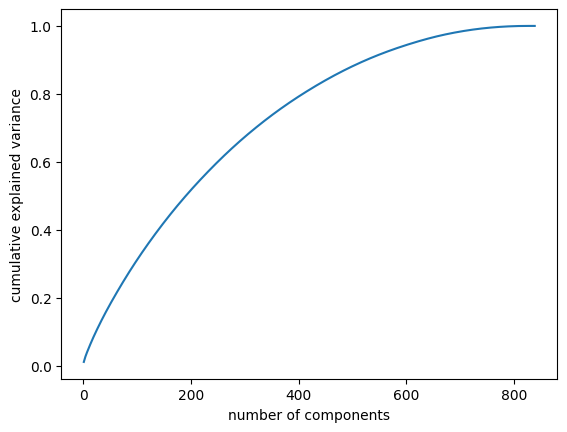

In [145]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(stand_X_tfidf)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)

print(f'number of components: {nc}')
print(f'cumulative explained variance: {ev}')

plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [95]:
import pandas as pd

# Keep only the first 2 components
pca = PCA(n_components = 2)

# Fit PCA and transform the data in the new coordinates
X_pca = pca.fit_transform(stand_X_tfidf)

# term-document matrix in the new coordinates
X_pca = pd.DataFrame(data = X_pca, columns = ['pc1', 'pc2'])
X_pca

,pc1,pc2
0,-1.726196,-0.431016
1,9.261476,0.176913
2,-2.693910,6.347322
3,-2.427567,-0.638765
4,-2.413804,-5.454454


In [96]:
test_docs

['#domanivotolega',
 'sorpresa devo essere sincero commosso cercato nasconderlo po figlio federico molto riservato me proprio aspettato p s domani voterà prima volta detto “ forse ” sceglierà lega 🥲 2/2',
 'ieri durante #maratonasalvini live canali social detto dietro quinte “ contributo sorpresa te ” 1/2',
 'intervista qualche giorno fa ve ripropongo #domanivotolega',
 'tre priorità lega guarda video amici domani decidete 7 23 andate votare #domanivotolega 💪']

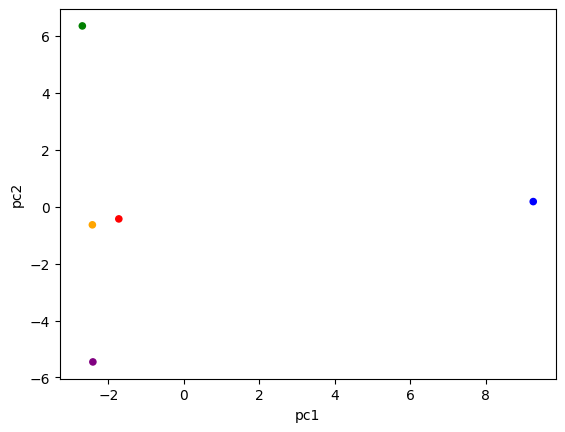

In [97]:
X_pca.plot(kind = 'scatter', x = 'pc1', y = 'pc2', color = ['red','blue','green','orange', 'purple'])
plt.show()

In [ ]:
cleaned_tweet = list()

for tweet in filtered_data["bonino"]:
    cleaned_tweet.append([tweet, tokenize(tweet)])

pd.DataFrame(cleaned_tweet).to_csv("TBD/test.csv")

## IS SPACY USEFUL?

In [79]:
# Punctuation cleaning

nlp = spacy.load("it_core_news_lg")

corpus = dict()
for politician in POLITICIANS:
    corpus[politician] = []
    for tweet in date_filtered_data[politician]:
        for sentence in nlp(tweet).sents:
            # TODO add readibility/ do better
            sentence_text_w_placeholder = re.sub('\+Europa', 'SPECIFICPOLITICALPARTYPLACEHOLDER', sentence.text, flags=re.IGNORECASE)
            cleaned_sentence_text = "".join([x for x in sentence_text_w_placeholder if x not in punctuation and x not in digits])
            corpus[politician].append(re.sub('SPECIFICPOLITICALPARTYPLACEHOLDER', '+Europa', cleaned_sentence_text))

In [97]:
# Tokenization, Lemmatization, StopWords Remover

tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["salvini"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [106]:
Xa.sum().sort_values(ascending=False)

settembrevotolega    197
lega                 181
settembre            148
italiano              96
italia                90
                    ... 
intelligenza           1
insicurezza            1
insetto                1
insegnamento           1
🥲                      1
Length: 1896, dtype: int64


In [107]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["calenda"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [108]:
Xa.sum().sort_values(ascending=False)

drago       137
paese       123
italia      106
pd          106
governo     103
           ... 
opinione      1
opificio      1
distanza      1
operaio       1
a             1
Length: 2408, dtype: int64

In [109]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["renzi"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
Xa.sum().sort_values(ascending=False)

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


secondo      17
drago        16
campagna     16
settembre    14
melone       14
             ..
giugno        1
giovedì       1
giovane       1
giorgia       1
♂             1
Length: 542, dtype: int64

In [110]:
tokenize = lambda text: [x.lemma_.lower() for x in nlp(text) if x.pos_ in ['NOUN', 'PROPN']]
vectorizer = CountVectorizer(tokenizer=tokenize)
X = vectorizer.fit_transform(corpus["conte"])
Xa = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
Xa.sum().sort_values(ascending=False)

/Users/teo/Documents/unimi/how-politician-change-their-mind/.venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sera          58
intervista    58
movstelle     56
grazie        40
diretta       32
              ..
lisola         2
linteresse     2
linea          2
limpegno       2
📺              2
Length: 672, dtype: int64

In [ ]:
def clean_data(corpus: list):
    # TODO
    return corpus

## Clean data

In [ ]:
out_data = clean_data(input_data)